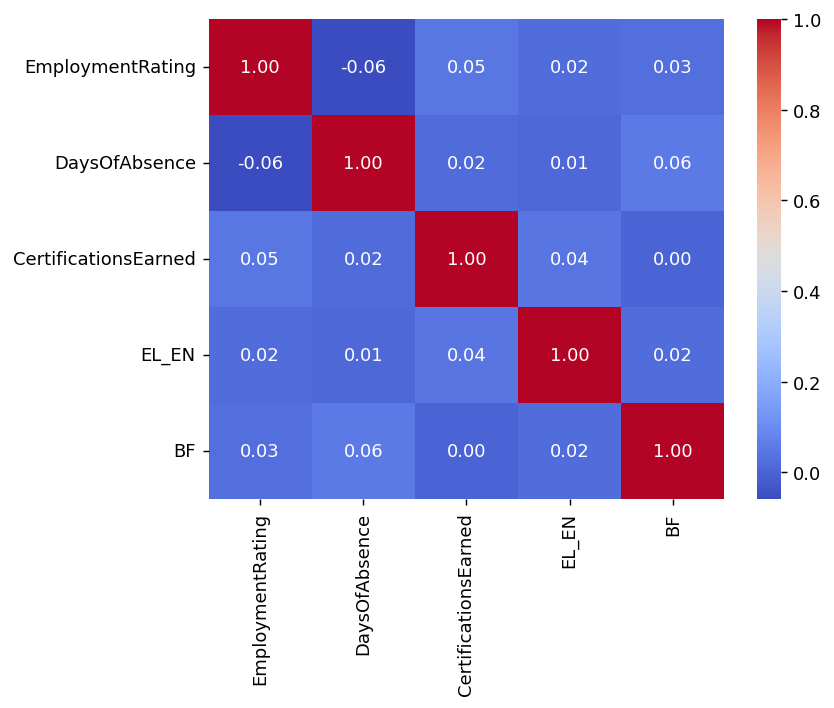

MAE: 0.1030447162032597
RMSE: 0.1173848864447444
Mean of bonus: 0.20189000000000001
254 employees received less than predicted
193 employees have 0 bonus


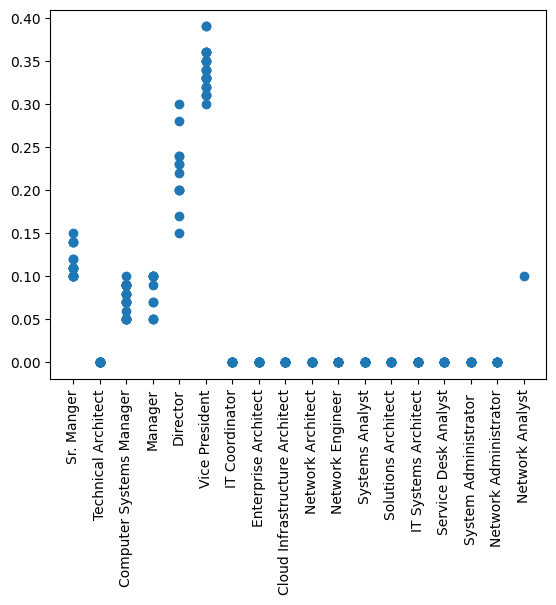

Number of employees with 0 bonus in training data: 23 out of 1000


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import math

emp_IT=pd.read_csv('C:/Users/dawod/OneDrive/Desktop/Training/estarta/SQL/CSVs/Employee_Profile_IT.csv')
#Cleaning Data
#Fill in missing ages based
emp_IT.fillna({'Age':emp_IT.groupby(['Job Title'])['Age'].transform('mean')},inplace=True)
emp_IT['Age']=emp_IT['Age'].astype(int)

#fill in missing annual salary
emp_IT['Annual Salary']=emp_IT['Annual Salary'].str.replace('$','')
emp_IT['Annual Salary']=emp_IT['Annual Salary'].str.replace(' ','')
emp_IT['Annual Salary']=emp_IT['Annual Salary'].str.replace(',','')
emp_IT['Annual Salary']=emp_IT['Annual Salary'].astype(float)
emp_IT.fillna({'Annual Salary':emp_IT.groupby(['Job Title'])['Annual Salary'].transform('mean')},inplace=True)

#Fix format of hire date and exit date
emp_IT['Hire Date']=pd.to_datetime(emp_IT['Hire Date'],format='%Y-%m-%d')
emp_IT['Exit Date']=pd.to_datetime(emp_IT['Exit Date'],format='%Y-%m-%d')

#fill in missing hire dates
emp_IT.fillna({'Hire Date':emp_IT.groupby(['Age'])['Hire Date'].transform('mean')},inplace=True)

#Filling missing ethnicities based on names
emp_IT.loc[emp_IT['EEID'] == 'E00816', 'Ethnicity'] = 'Caucasian'
emp_IT.loc[emp_IT['EEID'] == 'E02855', 'Ethnicity'] = 'Asian'

#Fill in missing Ethnicity and Country based on each other
emp_IT.loc[emp_IT['Country'] == 'Brazil', 'Ethnicity'] = emp_IT.loc[emp_IT['Country'] == 'Brazil', 'Ethnicity'].fillna('Latino')
emp_IT.loc[emp_IT['Country'] == 'China', 'Ethnicity'] = emp_IT.loc[emp_IT['Country'] == 'China', 'Ethnicity'].fillna('Asian')
emp_IT.loc[(emp_IT['Ethnicity'] == 'Black') | (emp_IT['Ethnicity'] == 'Caucasian'),'Country'] = emp_IT.loc[(emp_IT['Ethnicity'] == 'Black') | (emp_IT['Ethnicity'] == 'Caucasian'),'Country'].fillna('United States')

#Fill in missing bonus through ethnicity, gender, and job title
emp_IT.fillna({'Bonus %':emp_IT.groupby(['Ethnicity','Job Title','Gender'])['Bonus %'].transform('mean')},inplace=True)

#Fill in missing city based on country, and ethnicity
emp_IT['City'] = emp_IT['City'].fillna(emp_IT.groupby(['Country', 'Ethnicity'])['City'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan))

#Fill in missing Job Title based on ethnicity and annual salary
emp_IT.loc[emp_IT['EEID'] == 'E04116', 'Job Title'] = 'Director'
#Data cleaned except missing names



#Read training data
emp_B=pd.read_csv('C:/Users/dawod/OneDrive/Desktop/Training/estarta/SQL/Task2_SQL_and_ML/Task 2/DATA/Performance_Bonus.csv')

#Fix spelling error in column name
emp_B['Bonus']=emp_B['Bouns']
emp_B.drop(['Bouns'],axis=1,inplace=True)

#Adding bonus as float column
emp_B['BF']=emp_B['Bonus'].str.replace('%','').astype(float)
emp_B['BF']=emp_B['BF']

#Encoding education level
emp_B['EL_EN'] = emp_B['EducationLevel'].map({"Bachelor's":0,"Master's":1,"Doctorate":2})

#Removing the outliers:
q1, q3 = np.percentile(emp_B['BF'], [25, 75])
iqr = q3 - q1
upper = q3 + 1.5 * iqr
emp_B = emp_B[(emp_B['BF'] <= upper)]

#Setting the X and Y data
X=emp_B[['EmploymentRating','DaysOfAbsence','CertificationsEarned','EL_EN']]
y=emp_B['BF']

#Checking correlation
corr = emp_B[['EmploymentRating','DaysOfAbsence','CertificationsEarned','EL_EN','BF']].corr()
plt.figure(dpi=130)
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

#Seperating training and testing data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=35)

#Train the model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
from sklearn.metrics import mean_absolute_error,mean_squared_error

#Find the mae and rmse
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
rmse = mean_squared_error(y_true=y_test,y_pred=y_pred)
print("MAE:",mae/100)
print("RMSE:",math.sqrt(rmse)/100)
print("Mean of bonus:",(emp_B['BF']).mean()/100)

#Predicting bonus for IT employees
emp_IT['EL_EN']=emp_IT['EducationLevel'].map({"Bachelor's":0,"Master's":1,"PhD":2})
emp_IT['Predicted Bonus'] = model.predict(emp_IT[['EmploymentRating','DaysOfAbsence','CertificationsEarned','EL_EN']])


#Dropping temporary column
emp_IT.drop(['EL_EN'],axis=1,inplace=True)

#Show results
#print(emp_IT[['Predicted Bonus']].to_string())
#Count number of employees with less bonus than predicted ERROR HERE
count=0
count_O=0
for O, N in zip(emp_IT['Bonus %'], emp_IT['Predicted Bonus']/100):
    if O==0.00:
        count_O+=1
    if N>O:
        count+=1
print(count,'employees received less than predicted')
print(count_O,'employees have 0 bonus')

#Counting number of employees in the IT department with 0 bonus by job title
plt.scatter(emp_IT['Job Title'],emp_IT['Bonus %'])
plt.xticks(rotation=90)
plt.show()
print('Number of employees with 0 bonus in training data:',emp_B['BF'].loc[emp_B['BF']==0].count(),'out of',emp_B['BF'].count())

#Most employees received less than predicted, this data does not suggest employees re under-rewarded, as through breaking down the data from IT employees we realise that most IT employees do not recieve bonuses, in fact entire job titles do not recieve bonuses but the training data does not take that into account as it does not take into consideration department or job title, so it compares the training exit data which includes empoyees from all over the company, even tho employees from other departments could have different pay structures with lower salaries but higher bonuses